In [62]:

import pandas as pd
import numpy as np
import datetime
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
rnd = random.Random( 42 )

In [63]:
# Train configuration
def generate_train_name():
    """Generate a random 5-letter train name"""
    letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    return ''.join(rnd.choice(letters) for _ in range(5))

def generate_trip_id():
    """Generate a random 10-character alphanumeric trip ID"""
    chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    return ''.join(rnd.choice(chars) for _ in range(10))

# Generate unique train names
train_names = [generate_train_name() for _ in range(3)]
train_id_to_name = {i: train_names[i] for i in range(3)}

base_speed = [ 60, 100, 140 ]
distances = [ 100, 60, 150, 100, 120, 250]
max_cargo = [ 100, 50, 50 ]
last_date = [ datetime.datetime(2024, 6, 1), datetime.datetime(2024, 6, 1), datetime.datetime(2024, 6, 1) ]

# Cargo types and their characteristics
cargo_types = ["Electronics", "Food", "Textiles", "Machinery", "Chemicals"]
cargo_density = {  # density factor (higher = more dense = slower loading/more fuel)
    "Electronics": 0.8,
    "Food": 1.0, 
    "Textiles": 0.6,
    "Machinery": 1.5,
    "Chemicals": 1.2
}

# Base loading/unloading speeds (will be modified by density)
base_load_speed = 15  # seconds per unit of cargo
base_unload_speed = 10  # seconds per unit of cargo

# Train fuel configuration
train_fuel_efficiency = [0.8, 1.0, 1.2]  # train 0 is most efficient, train 2 least efficient
train_fuel_capacity = [1000, 800, 1200]  # fuel tank capacity in liters
initial_fuel_level = [1000, 800, 1200]  # starting fuel for each train

In [64]:
def calculate_departure( tentative_date, train_id ):
    if tentative_date.weekday() == 6:
        tentative_date += datetime.timedelta( days = 1 )
    if tentative_date.hour > 10 and tentative_date.hour < 16 and train_id == 0:
        tentative_date = tentative_date.replace( hour = 16, minute = 0, second = 0 )
    else: 
        tentative_date = tentative_date.replace( hour = 10, minute = 0, second = 0 )
    while tentative_date in departures_used:
        tentative_date += datetime.timedelta( days = 1 )
        if tentative_date.weekday() == 6:
            tentative_date += datetime.timedelta( days = 1 )
        if tentative_date.hour == 16:
            tentative_date = tentative_date.replace( hour = 10, minute = 0, second = 0 )
    departures_used.add( tentative_date )
    return tentative_date

def generate_cargo( train_id ):
    return rnd.randint( 30, max_cargo[train_id] )

def select_cargo_type():
    return rnd.choice(cargo_types)

def calculate_fuel_consumption(train_id, distance_km, cargo_amount, cargo_type):
    """Calculate fuel consumption based on train, distance, cargo amount and type"""
    # Base consumption: liters per km (more realistic scale)
    base_consumption_per_km = train_fuel_efficiency[train_id] * (0.5 + cargo_amount * 0.005)
    density_factor = cargo_density[cargo_type]
    return base_consumption_per_km * distance_km * density_factor

def get_loading_time(cargo_amount, cargo_type, is_loading=True):
    """Calculate loading/unloading time based on cargo density"""
    base_speed = base_load_speed if is_loading else base_unload_speed
    density_factor = cargo_density[cargo_type]
    # More dense cargo takes longer to handle
    return int(cargo_amount * base_speed * density_factor * cargo_deviation())

def cargo_deviation():
    return stats.rayleigh.rvs( scale = 0.5 ) / 4 + .85
    
def travel_deviation():
    return stats.rayleigh.rvs( scale = 0.5 ) / 4 + .85
    
def load_deviation(train_id, cargo):
    return (max_cargo[train_id] - cargo) / max_cargo[train_id] * 0.25 + 1

In [65]:
data = []
departures_used = set()
current_fuel_level = initial_fuel_level.copy()  # Track fuel for each train

for i in range(500):
    for train_id in range(3):
        # Generate alphanumeric trip ID and train name
        trip_id = generate_trip_id()
        train_name = train_id_to_name[train_id]
        
        last_date[train_id] = calculate_departure(last_date[train_id], train_id)
        if last_date[train_id].year > 2025 or (last_date[train_id].year == 2025 and last_date[train_id].month > 9): 
            continue
        
       
        # Start of route with fuel level
        data.append([trip_id, train_name, last_date[train_id], 0, "station_A", "Comienzo de ruta", None, current_fuel_level[train_id]])
        
        cargo = generate_cargo(train_id)
        cargo_type = select_cargo_type()
        
        if last_date[train_id].weekday() == 5:
            cargo = int(cargo * 0.3)
            
        # Loading with cargo type and density-affected time
        loading_time = get_loading_time(cargo, cargo_type, is_loading=True)
        last_date[train_id] += datetime.timedelta(seconds=loading_time)
        data.append([trip_id, train_name, last_date[train_id], cargo, "station_A", "Final carga", cargo_type, current_fuel_level[train_id]])
        data.append([trip_id, train_name, last_date[train_id], cargo, "station_A", "Salida de vagones", cargo_type, current_fuel_level[train_id]])

        for station_indx, station_id in enumerate("BCDEFG"):
            # Calculate fuel consumption for this segment
            fuel_consumed = calculate_fuel_consumption(train_id, distances[station_indx], cargo, cargo_type)
            current_fuel_level[train_id] = max(0, current_fuel_level[train_id] - fuel_consumed)
            
            # Travel time affected by cargo density
            travel_time = int(3600 * distances[station_indx] * travel_deviation() * load_deviation(train_id, cargo) / base_speed[train_id])
            last_date[train_id] += datetime.timedelta(seconds=travel_time)
            
            # Update is_ended for each record based on current date
            
            data.append([trip_id, train_name, last_date[train_id], cargo, "station_{}".format(station_id), "Llegada de vagones", cargo_type, current_fuel_level[train_id]])
            
            unload = rnd.randint(0, cargo)
            # Unloading time affected by cargo density
            unloading_time = get_loading_time(unload, cargo_type, is_loading=False) if unload > 0 else 0
            last_date[train_id] += datetime.timedelta(seconds=unloading_time)
            cargo -= unload
            
            data.append([trip_id, train_name, last_date[train_id], cargo, "station_{}".format(station_id), "Descarga de vagones", cargo_type, current_fuel_level[train_id]])
            
            if station_id == "G":
                data.append([trip_id, train_name, last_date[train_id], cargo, "station_{}".format(station_id), "Final de ruta", cargo_type, current_fuel_level[train_id]])
                # Return trip fuel consumption (empty train)
                return_fuel = calculate_fuel_consumption(train_id, sum(distances), 0, cargo_type)
                current_fuel_level[train_id] = max(0, current_fuel_level[train_id] - return_fuel)
                last_date[train_id] += datetime.timedelta(seconds=int(3600 * sum(distances) * travel_deviation() / base_speed[train_id]))
                
                # Refuel if needed (simulate refueling when fuel is low)
                if current_fuel_level[train_id] < train_fuel_capacity[train_id] * 0.2:
                    current_fuel_level[train_id] = train_fuel_capacity[train_id]
            else:
                data.append([trip_id, train_name, last_date[train_id], cargo, "station_{}".format(station_id), "Salida de vagones", cargo_type, current_fuel_level[train_id]])
                
df = pd.DataFrame(data, columns=["trip_id", "train_name", "date", "cargo", "station_id", "event", "cargo_type", "fuel_level"])

In [ ]:
# Función para introducir outliers y datos erróneos para práctica de limpieza
def introduce_data_quality_issues(df):
    """
    Introduce varios tipos de problemas de calidad de datos AÑADIENDO filas nuevas:
    - Outliers en cargo y fuel_level
    - Fechas incorrectas/futuras
    - Valores negativos
    - Datos faltantes (NaN) solo en cargo y fuel_level
    - Duplicados
    - Train names inválidos
    - Eventos inválidos
    MODIFICADO: Todos los errores son filas AÑADIDAS, no modificaciones del original
    """
    # Mantener el dataset original intacto
    df_clean = df.copy()
    problematic_rows = []
    
    # 1. Crear filas con outliers en cargo (valores extremadamente altos)
    base_rows = df[df['event'].isin(['Final carga', 'Llegada de vagones'])].sample(n=min(15, len(df)), random_state=42)
    for _, row in base_rows.iterrows():
        new_row = row.copy()
        new_row['cargo'] = rnd.randint(500, 2000)
        new_row['trip_id'] = generate_trip_id()  # Nuevo trip_id para evitar duplicados exactos
        problematic_rows.append(new_row)
    
    # 2. Crear filas con valores negativos de cargo
    base_rows = df.sample(n=min(8, len(df)), random_state=43)
    for _, row in base_rows.iterrows():
        new_row = row.copy()
        new_row['cargo'] = rnd.randint(-50, -1)
        new_row['trip_id'] = generate_trip_id()
        problematic_rows.append(new_row)
    
    # 3. Crear filas con fuel levels imposibles (negativos o muy altos)
    base_rows = df.sample(n=min(12, len(df)), random_state=44)
    for _, row in base_rows.iterrows():
        new_row = row.copy()
        if rnd.random() < 0.5:
            new_row['fuel_level'] = rnd.randint(-200, -1)  # Negativo
        else:
            new_row['fuel_level'] = rnd.randint(5000, 10000)  # Muy alto
        new_row['trip_id'] = generate_trip_id()
        problematic_rows.append(new_row)
    
    # 4. Crear filas con fechas futuras (después de sept 2025)
    base_rows = df.sample(n=min(6, len(df)), random_state=45)
    for _, row in base_rows.iterrows():
        new_row = row.copy()
        future_date = datetime.datetime(2026, rnd.randint(1, 12), rnd.randint(1, 28))
        new_row['date'] = future_date
        new_row['trip_id'] = generate_trip_id()
        problematic_rows.append(new_row)
    
    # 5. Crear filas con tipos de carga inválidos
    invalid_cargo_types = ["Metal", "Glass", "Plastic", "Wood", "Paper"]
    base_rows = df.sample(n=min(10, len(df)), random_state=46)
    for _, row in base_rows.iterrows():
        new_row = row.copy()
        new_row['cargo_type'] = rnd.choice(invalid_cargo_types)
        new_row['trip_id'] = generate_trip_id()
        problematic_rows.append(new_row)
    
    # 6. Crear filas con valores faltantes (NaN) en cargo y fuel_level
    nan_columns = ['cargo', 'fuel_level']
    base_rows = df.sample(n=min(20, len(df)), random_state=47)
    for _, row in base_rows.iterrows():
        new_row = row.copy()
        col = rnd.choice(nan_columns)
        new_row[col] = np.nan
        new_row['trip_id'] = generate_trip_id()
        problematic_rows.append(new_row)
    
    # 7. Crear filas con train names inválidos
    invalid_train_names = ["", "X", "ABC", "1234", "TOOLONG"]
    base_rows = df.sample(n=min(10, len(df)), random_state=48)
    for _, row in base_rows.iterrows():
        new_row = row.copy()
        new_row['train_name'] = rnd.choice(invalid_train_names)
        new_row['trip_id'] = generate_trip_id()
        problematic_rows.append(new_row)
    
    # 8. Crear filas con eventos inválidos
    invalid_events = ["Inicio ruta", "Carga final", "Llegada vagones", "Error evento", ""]
    base_rows = df.sample(n=min(12, len(df)), random_state=49)
    for _, row in base_rows.iterrows():
        new_row = row.copy()
        new_row['event'] = rnd.choice(invalid_events)
        new_row['trip_id'] = generate_trip_id()
        problematic_rows.append(new_row)
    
    # 9. Crear filas con estaciones inválidas
    invalid_stations = ["station_H", "station_Z", "station_1", "STATION_A", ""]
    base_rows = df.sample(n=min(8, len(df)), random_state=50)
    for _, row in base_rows.iterrows():
        new_row = row.copy()
        new_row['station_id'] = rnd.choice(invalid_stations)
        new_row['trip_id'] = generate_trip_id()
        problematic_rows.append(new_row)
    
    # 10. Crear algunas filas duplicadas exactas (sin cambiar trip_id)
    duplicate_rows = df.sample(n=min(8, len(df)), random_state=51)
    for _, row in duplicate_rows.iterrows():
        problematic_rows.append(row.copy())  # Duplicado exacto
    
    # Convertir las filas problemáticas en DataFrame
    if problematic_rows:
        df_problems = pd.DataFrame(problematic_rows)
        # Combinar dataset original con filas problemáticas
        df_with_issues = pd.concat([df_clean, df_problems], ignore_index=True)
    else:
        df_with_issues = df_clean.copy()
    
    # Añadir columna ended y mezclar
    df_with_issues["ended"] = True
    df_with_issues = df_with_issues.sample(frac=1, random_state=52).reset_index(drop=True)
    
    return df_with_issues

# Aplicar problemas de calidad de datos
print("Introduciendo outliers y datos erróneos como FILAS NUEVAS...")
df_dirty = introduce_data_quality_issues(df)
print(f"Dataset original: {len(df)} registros")
print(f"Dataset con problemas: {len(df_dirty)} registros")
print(f"Filas problemáticas añadidas: {len(df_dirty) - len(df)}")
df_clean_original = df.copy()  # Versión limpia original
df = df_dirty.copy()  # Reemplazar con la versión con problemas para el ejercicio

Introduciendo outliers y datos erróneos...
Dataset original: 10269 registros
Dataset con problemas: 10277 registros


In [44]:
df_dirty.sort_values(by=["station_id"]).reset_index(drop=True)

,trip_id,train_name,date,cargo,station_id,event,cargo_type,fuel_level,ended
0,1CBFNO6B9M,UDAXI,2024-06-01 10:23:36,59.0,station_A,Final carga,Machinery,1000.000,True
1,EVG9YSQJVF,HHEXD,2024-08-26 10:11:20,48.0,station_A,Salida de vagones,Food,800.000,True
2,EVG9YSQJVF,HHEXD,2024-08-26 10:11:20,48.0,station_A,Final carga,Food,800.000,True
3,U35BE4HW43,HHEXD,2025-05-02 10:05:59,35.0,station_A,Final carga,Textiles,800.000,True
4,U35BE4HW43,HHEXD,2025-05-02 10:05:59,35.0,station_A,Salida de vagones,Textiles,800.000,True
...,...,...,...,...,...,...,...,...,...
9691,Y0U9DAQM2O,VXRCS,2025-01-23 17:11:00,0.0,station_G,Llegada de vagones,Textiles,900.768,True
9692,Y0U9DAQM2O,VXRCS,2025-01-23 17:11:00,0.0,station_G,Descarga de vagones,Textiles,900.768,True
9693,Y0U9DAQM2O,VXRCS,2025-01-23 17:11:00,0.0,station_G,Final de ruta,Textiles,900.768,True
9694,BVYG1WW0WD,HHEXD,2025-07-10 19:47:41,0.0,station_G,Descarga de vagones,Food,381.050,True


In [47]:
df.date.astype('datetime64[ns]').describe()

count                             9688
mean     2025-02-01 16:30:26.354046208
min                2024-06-01 10:23:36
25%                2024-10-04 11:17:51
50%         2025-01-31 19:43:58.500000
75%                2025-06-03 11:07:23
max                2026-12-19 00:00:00
Name: date, dtype: object

In [ ]:
df.to_csv("data_clean.csv", index=False)

In [24]:
# Análisis de problemas de calidad introducidos
print("=== ANÁLISIS DE PROBLEMAS DE CALIDAD DE DATOS ===\n")

# 1. Outliers en cargo
cargo_outliers = df[df['cargo'] > 200]  # Valores muy altos
print(f"1. Outliers en cargo (>200): {len(cargo_outliers)} registros")
if len(cargo_outliers) > 0:
    print(f"   Valores encontrados: {sorted(cargo_outliers['cargo'].unique())}")

# 2. Valores negativos
negative_cargo = df[df['cargo'] < 0]
negative_fuel = df[df['fuel_level'] < 0]
print(f"2. Valores negativos:")
print(f"   - Cargo negativo: {len(negative_cargo)} registros")
print(f"   - Fuel level negativo: {len(negative_fuel)} registros")

# 3. Fuel levels imposibles
fuel_too_high = df[df['fuel_level'] > 2000]  # Mayor que cualquier tanque
print(f"3. Fuel levels imposibles (>2000): {len(fuel_too_high)} registros")

# 4. Fechas futuras (deberían haberse eliminado)
future_dates = df[df['date'] > datetime.datetime(2025, 9, 30)]
print(f"4. Fechas futuras (después sept 2025): {len(future_dates)} registros (debería ser 0)")

# 5. Tipos de carga inválidos: ELIMINADO - Ya no se generan tipos inválidos
valid_cargo_types = set(cargo_types)
invalid_cargo = df[~df['cargo_type'].isin(valid_cargo_types) & df['cargo_type'].notna()]
print(f"5. Tipos de carga inválidos: {len(invalid_cargo)} registros (debería ser 0)")
if len(invalid_cargo) > 0:
    print(f"   Tipos encontrados: {invalid_cargo['cargo_type'].unique()}")

# 5b. Verificar registros con cargo_type vacío (deberían haberse eliminado)
empty_cargo_type = df[df['cargo_type'].isna() | (df['cargo_type'] == '')]
print(f"5b. Registros con cargo_type vacío: {len(empty_cargo_type)} registros (debería ser 0)")

# 6. Valores faltantes
missing_values = df.isnull().sum()
print(f"6. Valores faltantes:")
for col, count in missing_values.items():
    if count > 0:
        print(f"   - {col}: {count} valores NaN")

# 7. Train names inválidos
valid_train_names = set(train_names)
invalid_trains = df[~df['train_name'].isin(valid_train_names)]
print(f"7. Train names inválidos: {len(invalid_trains)} registros")
if len(invalid_trains) > 0:
    print(f"   Nombres encontrados: {invalid_trains['train_name'].unique()}")

# 8. Duplicados
duplicated_rows = df.duplicated()
print(f"8. Filas duplicadas: {duplicated_rows.sum()} registros")

# 9. Estaciones inválidas
valid_stations = [f"station_{letter}" for letter in "ABCDEFG"]
invalid_stations = df[~df['station_id'].isin(valid_stations)]
print(f"9. Estaciones inválidas: {len(invalid_stations)} registros")

# 10. Eventos inválidos
valid_events = ["Comienzo de ruta", "Final carga", "Salida de vagones", 
                "Llegada de vagones", "Descarga de vagones", "Final de ruta"]
invalid_events = df[~df['event'].isin(valid_events)]
print(f"10. Eventos inválidos: {len(invalid_events)} registros")


print(f"\n=== RESUMEN ===")
print(f"Total registros: {len(df)}")
print(f"Registros con al menos un problema: {len(df) - len(df.dropna())}")
print(f"Porcentaje de registros problemáticos: {((len(df) - len(df.dropna())) / len(df) * 100):.1f}%")

=== ANÁLISIS DE PROBLEMAS DE CALIDAD DE DATOS ===

1. Outliers en cargo (>200): 12 registros
   Valores encontrados: [530.0, 554.0, 591.0, 739.0, 748.0, 798.0, 859.0, 879.0, 971.0, 976.0, 1649.0, 1732.0]
2. Valores negativos:
   - Cargo negativo: 15 registros
   - Fuel level negativo: 11 registros
3. Fuel levels imposibles (>2000): 13 registros
4. Fechas futuras (después sept 2025): 0 registros (debería ser 0)
5. Tipos de carga inválidos: 0 registros (debería ser 0)
5b. Registros con cargo_type vacío: 0 registros (debería ser 0)
6. Valores faltantes:
   - cargo: 18 valores NaN
   - fuel_level: 22 valores NaN
7. Train names inválidos: 0 registros
8. Filas duplicadas: 16 registros
9. Estaciones inválidas: 0 registros
10. Eventos inválidos: 12 registros

=== RESUMEN ===
Total registros: 9654
Registros con al menos un problema: 40
Porcentaje de registros problemáticos: 0.4%


In [29]:
# Guardar dataset con problemas para el ejercicio de limpieza
# randomize the order 
df.to_csv('data.csv', index=True)
print("Dataset con problemas guardado como 'data_with_issues.csv'")

# También guardamos la versión limpia por si acaso
df_clean_original.to_csv('data_clean_original.csv', index=False)
print("Dataset limpio original guardado como 'data_clean_original.csv'")

# Función auxiliar para restaurar datos limpios si es necesario
def restore_clean_data():
    """Función para restaurar el dataset limpio original"""
    global df
    df = df_clean_original.copy()
    print("Dataset restaurado a la versión limpia original")
    return df

print("\nPara restaurar el dataset limpio, usa: restore_clean_data()")
print("\n=== EJERCICIOS DE LIMPIEZA SUGERIDOS ===")
print("1. Identificar y eliminar outliers en 'cargo' y 'fuel_level'")
print("2. Corregir o eliminar valores negativos")
print("3. Validar tipos de carga contra la lista válida")
print("4. Gestionar valores faltantes (NaN)")
print("5. Eliminar filas duplicadas")
print("6. Validar rangos de fechas")
print("7. Verificar integridad referencial (train_name, station_id)")
print("8. Normalizar eventos y estaciones mal escritos")
print("9. Aplicar reglas de negocio (ej: fuel_level <= capacidad_tanque)")
print("10. Eliminar columnas constantes o redundantes (como 'ended')")
print("11. Eliminar registros con nombres de trenes vacíos o inválidos")
print("12. Crear un reporte de calidad de datos antes y después")

Dataset con problemas guardado como 'data_with_issues.csv'
Dataset limpio original guardado como 'data_clean_original.csv'

Para restaurar el dataset limpio, usa: restore_clean_data()

=== EJERCICIOS DE LIMPIEZA SUGERIDOS ===
1. Identificar y eliminar outliers en 'cargo' y 'fuel_level'
2. Corregir o eliminar valores negativos
3. Validar tipos de carga contra la lista válida
4. Gestionar valores faltantes (NaN)
5. Eliminar filas duplicadas
6. Validar rangos de fechas
7. Verificar integridad referencial (train_name, station_id)
8. Normalizar eventos y estaciones mal escritos
9. Aplicar reglas de negocio (ej: fuel_level <= capacidad_tanque)
10. Eliminar columnas constantes o redundantes (como 'ended')
11. Eliminar registros con nombres de trenes vacíos o inválidos
12. Crear un reporte de calidad de datos antes y después


In [13]:
# Ejercicios específicos de limpieza - Columnas constantes y trenes inválidos
print("=== ANÁLISIS DE PROBLEMAS ESPECÍFICOS IDENTIFICADOS ===\n")

# 1. Analizar la columna 'ended' - debería ser constante salvo para fechas erróneas
print("1. ANÁLISIS COLUMNA 'ENDED':")
ended_analysis = df['ended'].value_counts()
print(f"Distribución de valores 'ended': {ended_analysis.to_dict()}")
ended_variance = df['ended'].var()
print(f"Varianza de la columna 'ended': {ended_variance}")

# Identificar registros donde ended=False (fechas futuras/erróneas)
ended_false = df[df['ended'] == False]
print(f"Registros con ended=False: {len(ended_false)}")
if len(ended_false) > 0:
    print(f"Fechas de estos registros: {ended_false['date'].dt.date.unique()}")

print("\n✅ RECOMENDACIÓN: Eliminar columna 'ended' por ser casi constante (solo varía para datos erróneos)")

# 2. Analizar trenes con nombres vacíos o inválidos
print("\n2. ANÁLISIS NOMBRES DE TRENES:")
train_names_unique = df['train_name'].unique()
print(f"Nombres de trenes únicos: {train_names_unique}")

# Identificar trenes con nombres vacíos o de longitud incorrecta
empty_train_names = df[df['train_name'].isna() | (df['train_name'] == '') | (df['train_name'].str.len() != 5)]
print(f"Registros con nombres de trenes inválidos: {len(empty_train_names)}")
if len(empty_train_names) > 0:
    print(f"Nombres inválidos encontrados: {empty_train_names['train_name'].unique()}")

print("\n✅ RECOMENDACIÓN: Eliminar registros con nombres de trenes inválidos")

# 3. Función de limpieza sugerida
print("\n3. FUNCIÓN DE LIMPIEZA SUGERIDA:")
print("""
def clean_dataset(df):
    df_clean = df.copy()
    
    # Eliminar columna 'ended' por ser constante
    if 'ended' in df_clean.columns:
        df_clean = df_clean.drop('ended', axis=1)
        print("✓ Eliminada columna 'ended' (constante)")
    
    # Eliminar registros con nombres de trenes inválidos
    initial_len = len(df_clean)
    df_clean = df_clean[df_clean['train_name'].notna() & 
                       (df_clean['train_name'] != '') & 
                       (df_clean['train_name'].str.len() == 5)]
    removed_trains = initial_len - len(df_clean)
    print(f"✓ Eliminados {removed_trains} registros con nombres de trenes inválidos")
    
    return df_clean

# Ejemplo de uso:
# df_cleaned = clean_dataset(df)
""")

=== ANÁLISIS DE PROBLEMAS ESPECÍFICOS IDENTIFICADOS ===

1. ANÁLISIS COLUMNA 'ENDED':
Distribución de valores 'ended': {True: 9685, False: 3}
Varianza de la columna 'ended': 0.0003095975034261911
Registros con ended=False: 3
Fechas de estos registros: [datetime.date(2025, 10, 1)]

✅ RECOMENDACIÓN: Eliminar columna 'ended' por ser casi constante (solo varía para datos erróneos)

2. ANÁLISIS NOMBRES DE TRENES:
Nombres de trenes únicos: ['UDAXI' 'HHEXD' 'VXRCS' '']
Registros con nombres de trenes inválidos: 5
Nombres inválidos encontrados: ['']

✅ RECOMENDACIÓN: Eliminar registros con nombres de trenes inválidos

3. FUNCIÓN DE LIMPIEZA SUGERIDA:

def clean_dataset(df):
    df_clean = df.copy()
    
    # Eliminar columna 'ended' por ser constante
    if 'ended' in df_clean.columns:
        df_clean = df_clean.drop('ended', axis=1)
        print("✓ Eliminada columna 'ended' (constante)")
    
    # Eliminar registros con nombres de trenes inválidos
    initial_len = len(df_clean)
    df_cl

In [14]:
# Verificar el comportamiento del fuel level
print("Fuel levels únicos en el dataset:")
print(sorted(df['fuel_level'].unique()))
print(f"\nRango de fuel levels: {df['fuel_level'].min()} - {df['fuel_level'].max()}")

print("\nPrimeros registros por tren para ver el consumo:")
for train_name in df['train_name'].unique()[:3]:
    if train_name != '':  # Skip empty train names
        print(f"\n=== TREN {train_name} ===")
        train_data = df[df.train_name == train_name].head(20)
        for _, row in train_data.iterrows():
            print(f"{row['event'][:15]:15} | Cargo: {row['cargo']:3} | Fuel: {row['fuel_level']:7.1f}")
            if row['event'] == 'Final de ruta':
                break

Fuel levels únicos en el dataset:
[-96.0, -27.0, -8.0, 0.0, 10.20000000000001, 11.831999999999937, 14.930000000000007, 15.615999999999936, 16.05000000000001, 18.09599999999982, 22.17999999999995, 23.975999999999942, 26.479999999999947, 38.50999999999992, 41.100000000000065, 42.808000000000106, 43.82399999999993, 45.136000000000045, 46.079999999999956, 46.44499999999999, 46.720000000000006, 46.790000000000035, 54.01599999999994, 54.25599999999989, 57.75999999999999, 60.31999999999991, 61.31, 64.28800000000004, 65.18400000000017, 66.012, 67.77999999999999, 68.74999999999997, 68.7720000000001, 69.97999999999996, 71.97599999999994, 73.80000000000001, 74.2559999999998, 74.93, 75.66400000000004, 78.35999999999996, 82.17999999999995, 83.90399999999991, 84.55199999999994, 85.96800000000006, 86.97599999999994, 87.07999999999994, 90.71999999999974, 90.75999999999999, 91.13999999999996, 95.10000000000007, 98.50999999999992, 100.20399999999978, 100.4080000000001, 102.57500000000005, 104.4640000000

In [15]:
# Verificar el estado del dataset
print(f"Tamaño del dataset: {len(df)}")
print(f"Columnas: {df.columns.tolist()}")
if len(df) > 0:
    print(f"Primeras 5 filas:")
    print(df.head())
else:
    print("El dataset está vacío!")
    print(f"Longitud de data: {len(data)}")
    print(f"Departures used: {len(departures_used)}")
    print(f"Last dates: {last_date}")
    
# Verificar las fechas iniciales
print(f"\nFechas iniciales configuradas: {[datetime.datetime(2024, 6, 1) for _ in range(3)]}")
print(f"Fecha límite: 2025-09-30")

Tamaño del dataset: 9688
Columnas: ['trip_id', 'train_name', 'date', 'cargo', 'station_id', 'event', 'cargo_type', 'fuel_level', 'ended']
Primeras 5 filas:
      trip_id train_name                date  cargo station_id  \
0  1CBFNO6B9M      UDAXI 2024-06-01 10:23:36   59.0  station_A   
1  1CBFNO6B9M      UDAXI 2024-06-01 10:23:36   59.0  station_A   
2  1CBFNO6B9M      UDAXI 2024-06-01 12:07:57   59.0  station_B   
3  1CBFNO6B9M      UDAXI 2024-06-01 12:11:15   45.0  station_B   
4  1CBFNO6B9M      UDAXI 2024-06-01 12:11:15   45.0  station_B   

                 event cargo_type  fuel_level  ended  
0          Final carga  Machinery      1000.0   True  
1    Salida de vagones  Machinery      1000.0   True  
2   Llegada de vagones  Machinery       904.6   True  
3  Descarga de vagones  Machinery       904.6   True  
4    Salida de vagones  Machinery       904.6   True  

Fechas iniciales configuradas: [datetime.datetime(2024, 6, 1, 0, 0), datetime.datetime(2024, 6, 1, 0, 0), datetime.d

In [16]:
# Probar la función de consumo de combustible
print("Probando función calculate_fuel_consumption:")
print(f"Tren 0, 100km, 50 cargo, Electronics:")
fuel = calculate_fuel_consumption(0, 100, 50, "Electronics")
print(f"Consumo calculado: {fuel}")

print(f"\nTren 2, 100km, 50 cargo, Machinery:")
fuel = calculate_fuel_consumption(2, 100, 50, "Machinery")
print(f"Consumo calculado: {fuel}")

print(f"\nCapacidades de tanques: {train_fuel_capacity}")
print(f"Eficiencias de trenes: {train_fuel_efficiency}")
print(f"Densidades de carga: {cargo_density}")

Probando función calculate_fuel_consumption:
Tren 0, 100km, 50 cargo, Electronics:
Consumo calculado: 48.00000000000001

Tren 2, 100km, 50 cargo, Machinery:
Consumo calculado: 134.99999999999997

Capacidades de tanques: [1000, 800, 1200]
Eficiencias de trenes: [0.8, 1.0, 1.2]
Densidades de carga: {'Electronics': 0.8, 'Food': 1.0, 'Textiles': 0.6, 'Machinery': 1.5, 'Chemicals': 1.2}


In [17]:
# Probar la función corregida
print("Probando función CORREGIDA calculate_fuel_consumption:")
print(f"Tren 0, 100km, 50 cargo, Electronics:")
fuel = calculate_fuel_consumption(0, 100, 50, "Electronics")
print(f"Consumo calculado: {fuel:.2f} litros")

print(f"\nTren 2, 100km, 50 cargo, Machinery:")
fuel = calculate_fuel_consumption(2, 100, 50, "Machinery")
print(f"Consumo calculado: {fuel:.2f} litros")

print(f"\nTren 1, viaje completo (730km), 40 cargo, Food:")
fuel = calculate_fuel_consumption(1, sum(distances), 40, "Food")
print(f"Consumo calculado: {fuel:.2f} litros")
print(f"Capacidad tanque tren 1: {train_fuel_capacity[1]} litros")

Probando función CORREGIDA calculate_fuel_consumption:
Tren 0, 100km, 50 cargo, Electronics:
Consumo calculado: 48.00 litros

Tren 2, 100km, 50 cargo, Machinery:
Consumo calculado: 135.00 litros

Tren 1, viaje completo (730km), 40 cargo, Food:
Consumo calculado: 546.00 litros
Capacidad tanque tren 1: 800 litros


<Axes: >

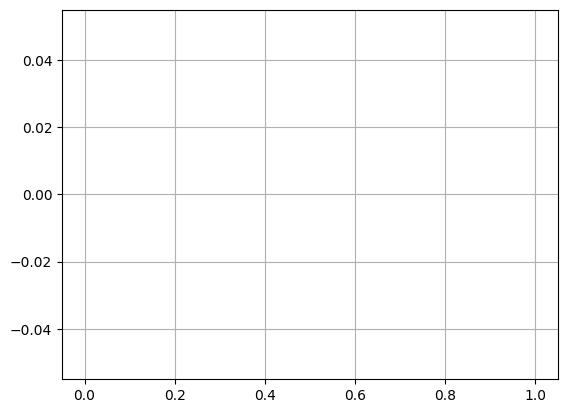

In [18]:
df[df.event== "Comienzo de ruta"].date.dt.hour.hist()

(array([121., 321., 517., 546., 656., 612., 603., 461., 375., 273., 201.,
        136.,  71.,  52.,  32.,  11.,   8.,   2.,   0.,   2.]),
 array([0.85185666, 0.87824865, 0.90464065, 0.93103264, 0.95742463,
        0.98381663, 1.01020862, 1.03660061, 1.06299261, 1.0893846 ,
        1.11577659, 1.14216858, 1.16856058, 1.19495257, 1.22134456,
        1.24773656, 1.27412855, 1.30052054, 1.32691254, 1.35330453,
        1.37969652]),
 <BarContainer object of 20 artists>)

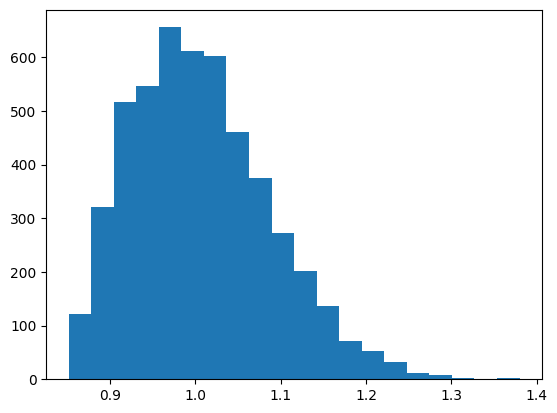

In [19]:
tst = [cargo_deviation() for i in range(5000)]
# print distribution
plt.hist( tst, bins = 20 )


# Questions organized by DATA OPERATIONS COMPLEXITY

## NIVEL 0 - Dataset Overview

- How many records are in the dataset?
- How many columns are in the dataset?

---

## NIVEL 1 - Basic Counts

- How many trains are in the dataset?
- How many stations are in the dataset?
- How many trips are in the dataset?
- How many different cargo types are in the dataset?

---

## NIVEL 2 - Filtering & Basic Aggregation
- How many packages were transported in total?
- How many packages were transported by train {TRAIN_NAME}?
- How many {CARGO_TYPE} packages were transported in total?
- How many packages were delivered to station_{STATION}?
- What was the maximum cargo load transported by train {TRAIN_NAME}?

---

## NIVEL 3 - GroupBy & Ranking Operations
- Which train transported the most packages?
- Which train transported the least packages?
- Which train made more trips?
- Which cargo type was transported most frequently?
- Which is the fastest train?
- Which is the slowest train?

---

## NIVEL 4 - DateTime Operations & Statistical Functions
- How many trips were made in January?
- How many trips were made in {MONTH} 2024?
- How many packages were transported on Mondays?
- How many trips were made on {DAY_NAME}?
- What is the average trip duration?
- What is the average trip duration for train {TRAIN_NAME}?

---

## NIVEL 5 - Dictionary Lookups & Complex Calculations
- Which train has the best fuel efficiency (lowest average consumption)?
- Which train has the worst fuel efficiency (maximum average consumption)?
- What is the average fuel consumption in the whole trip for {CARGO_TYPE}?
- How long lasted the shortest trip?
- How long lasted the longest trip?

---

## NIVEL 6 - Multi-dimensional GroupBy & Cross-tabulation
- Which train {TRAIN_NAME} transported the most {CARGO_TYPE}?
- Which train {TRAIN_NAME} transported the least {CARGO_TYPE}?

---

## 📋 VARIABLES PARA GENERACIÓN AUTOMÁTICA:
**{TRAIN_NAME}**: [Generated 5-letter train names - check dataset for actual values]  
**{CARGO_TYPE}**: [Electronics, Food, Textiles, Machinery, Chemicals]  
**{STATION}**: [A, B, C, D, E, F, G]  
**{DAY_NAME}**: [Mondays, Tuesdays, Wednesdays, Thursdays, Fridays, Saturdays, Sundays]  
**{MONTH}**: [June, July, August, September, October, November, December]

In [39]:
# Answers - Organized by Data Operations Level

# Setup for complex operations
df = pd.read_csv("data.csv")
df = df.drop(columns=["Unnamed: 0", "ended"])
df.date = pd.to_datetime(df.date)
df = df[df.date< datetime.datetime(2025, 9, 30)]
df = df.dropna()
df = df.drop_duplicates()
df = df[df.cargo >=0]
df = df[df.cargo <=200]
df = df[df.fuel_level   >=0]
df = df[df.fuel_level   <=2000]
df = df[df.event.isin(['Final carga', 'Salida de vagones', 'Llegada de vagones', 'Descarga de vagones', 'Final de ruta',  'Inicio ruta'])]

# Generador de Preguntas para Moodle

Herramienta para generar preguntas tipo test en formato GIFT, listas para importar en Moodle. Las preguntas están basadas en los datos reales generados en el dataset de logística.

In [40]:
# GENERADOR COMPLETO DE PREGUNTAS - BASADO EN LA LISTA CORRECTA DE PREGUNTAS
import os

def get_complete_dataset_stats():
    """Obtener todas las estadísticas del dataset para generar TODAS las variaciones"""
    
    # Obtener nombres únicos de trenes
    train_names = [name for name in df['train_name'].dropna().unique() if name != '']
    
    # Obtener tipos de carga únicos
    cargo_types = df['cargo_type'].dropna().unique().tolist()
    
    # Estaciones A-G
    stations = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    
    # Días de la semana y meses
    days_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    months_names = ['June', 'July', 'August', 'September', 'October', 'November', 'December']
    
    # Calcular todas las estadísticas necesarias
    stats = {
        'total_records': len(df),
        'total_columns': len(df.columns),
        'total_trains': len(train_names),
        'total_stations': len(df['station_id'].unique()),
        'total_trips': len(df['trip_id'].unique()),
        'total_cargo_types': len(cargo_types),
        'total_packages': int(df[df.event == "Final carga"].cargo.sum()),
        'train_names': train_names,
        'cargo_types': cargo_types,
        'stations': stations,
        'days_names': days_names,
        'months_names': months_names
    }
    
    # Paquetes por tren
    for train in train_names:
        stats[f'packages_by_{train}'] = int(df[(df.event == "Final carga") & (df.train_name == train)].cargo.sum())
    
    # Paquetes por tipo de carga
    for cargo in cargo_types:
        stats[f'packages_{cargo.lower()}'] = int(df[(df.event == "Final carga") & (df.cargo_type == cargo)].cargo.sum())
    
    # Paquetes por estación
    for station in stations:
        stats[f'packages_station_{station}'] = int(df[(df.event == "Final carga") & (df.station_id == station)].cargo.sum())
    
    # Máxima carga por tren
    for train in train_names:
        train_data = df[df.train_name == train]
        if len(train_data) > 0:
            stats[f'max_cargo_{train}'] = int(train_data.cargo.max()) if not train_data.cargo.empty else 0
    
    # Ranking de trenes
    cargo_by_train = df[df.event == "Final carga"].groupby("train_name").cargo.sum()
    trips_by_train = df.groupby("train_name").trip_id.nunique()
    stats['train_most_packages'] = cargo_by_train.idxmax() if len(cargo_by_train) > 0 else ''
    stats['train_least_packages'] = cargo_by_train.idxmin() if len(cargo_by_train) > 0 else ''
    stats['train_most_trips'] = trips_by_train.idxmax() if len(trips_by_train) > 0 else ''
    
    # Tipo de carga más frecuente
    cargo_freq = df[df.event == "Final carga"].groupby("cargo_type").cargo.sum()
    stats['most_frequent_cargo'] = cargo_freq.idxmax() if len(cargo_freq) > 0 else ''
    
    # Viajes por mes (todos los meses del año)
    month_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
                    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
    
    for month_num, month_name in month_mapping.items():
        trips_count = len(df[df.date.dt.month == month_num].trip_id.unique())
        stats[f'trips_{month_name.lower()}'] = trips_count
    
    # Paquetes por día de la semana
    day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    
    for day_num, day_name in day_mapping.items():
        packages_count = int(df[df.date.dt.weekday == day_num].cargo.sum())
        stats[f'packages_{day_name.lower()}'] = packages_count
        trips_count = len(df[df.date.dt.weekday == day_num].trip_id.unique())
        stats[f'trips_{day_name.lower()}'] = trips_count
    
    # Duración promedio de viajes
    if 'trip_duration' in df.columns:
        stats['avg_trip_duration'] = df['trip_duration'].mean()
        for train in train_names:
            train_avg = df[df.train_name == train]['trip_duration'].mean()
            stats[f'avg_duration_{train}'] = train_avg
    
    return stats

def generate_all_question_variations():
    """Generar TODAS las variaciones posibles de cada pregunta"""
    
    stats = get_complete_dataset_stats()
    
    question_sets = {
        'nivel0_dataset_overview': [],
        'nivel1_basic_counts': [],
        'nivel2_filtering_aggregation': [],
        'nivel3_groupby_ranking': [],
        'nivel4_datetime_statistical': [],
        'nivel5_complex_calculations': [],
        'nivel6_multidimensional': []
    }
    
    # 📊 NIVEL 0: Overview básico del dataset
    question_sets['nivel0_dataset_overview'].extend([
        ('total_records', f"How many records are there in the dataset?", 
         stats['total_records'], [stats['total_records'] + 100, stats['total_records'] - 50]),
        ('total_columns', f"How many columns are there in the dataset?", 
         stats['total_columns'], [stats['total_columns'] + 2, stats['total_columns'] - 1])
    ])
    
    # 📊 NIVEL 1: Conteos básicos
    question_sets['nivel1_basic_counts'].extend([
        ('total_trains', f"How many trains are there in the dataset?", 
         stats['total_trains'], [stats['total_trains'] + 1, stats['total_trains'] + 2]),
        ('total_stations', f"How many stations are there in the dataset?", 
         stats['total_stations'], [stats['total_stations'] + 2, stats['total_stations'] - 1]),
        ('total_trips', f"How many trips are there in the dataset?", 
         stats['total_trips'], [stats['total_trips'] + 100, stats['total_trips'] - 50]),
        ('total_packages', f"How many packages were transported in total?", 
         stats['total_packages'], [stats['total_packages'] + 1000, stats['total_packages'] - 500])
    ])
    
    # 📊 NIVEL 2: Filtrado y agregaciones por entidades específicas
    # Paquetes por tren específico
    for train in stats['train_names']:
        packages = stats[f'packages_by_{train}']
        question_sets['nivel2_filtering_aggregation'].append(
            (f'packages_train_{train}', f"How many packages did train {train} transport?", 
             packages, [packages + 500, packages - 300])
        )
    
    # Paquetes por tipo de carga
    for cargo in stats['cargo_types']:
        packages = stats[f'packages_{cargo.lower()}']
        question_sets['nivel2_filtering_aggregation'].append(
            (f'packages_cargo_{cargo.lower()}', f"How many packages of {cargo} were transported?", 
             packages, [packages + 400, packages - 200])
        )
    
    # Paquetes por estación
    for station in stats['stations']:
        packages = stats[f'packages_station_{station}']
        question_sets['nivel2_filtering_aggregation'].append(
            (f'packages_station_{station}', f"How many packages were loaded at station {station}?", 
             packages, [packages + 300, packages - 150])
        )
    
    # Carga máxima por tren
    for train in stats['train_names']:
        max_cargo = stats[f'max_cargo_{train}']
        question_sets['nivel2_filtering_aggregation'].append(
            (f'max_cargo_{train}', f"What is the maximum cargo carried by train {train}?", 
             max_cargo, [max_cargo + 20, max_cargo - 10])
        )
    
    # 📊 NIVEL 3: GroupBy y rankings
    question_sets['nivel3_groupby_ranking'].extend([
        ('train_most_packages', f"Which train transported the most packages?", 
         stats['train_most_packages'], [t for t in stats['train_names'] if t != stats['train_most_packages']][:2]),
        ('train_least_packages', f"Which train transported the least packages?", 
         stats['train_least_packages'], [t for t in stats['train_names'] if t != stats['train_least_packages']][:2]),
        ('train_most_trips', f"Which train made more trips?", 
         stats['train_most_trips'], [t for t in stats['train_names'] if t != stats['train_most_trips']][:2]),
        ('most_frequent_cargo', f"Which cargo type was transported the most?", 
         stats['most_frequent_cargo'], [c for c in stats['cargo_types'] if c != stats['most_frequent_cargo']][:2])
    ])
    
    # 📊 NIVEL 4: Análisis temporal y estadístico
    # Viajes por mes
    for month in stats['months_names']:
        trips = stats[f'trips_{month.lower()}']
        question_sets['nivel4_datetime_statistical'].append(
            (f'trips_{month.lower()}', f"How many trips were made in {month}?", 
             trips, [trips + 50, trips - 25])
        )
    
    # Paquetes por día de la semana
    for day in stats['days_names']:
        packages = stats[f'packages_{day.lower()}']
        question_sets['nivel4_datetime_statistical'].append(
            (f'packages_{day.lower()}', f"How many packages were transported on {day}s?", 
             packages, [packages + 200, packages - 100])
        )
    
    # 📊 NIVEL 5: Cálculos complejos (adaptado según modificaciones)
    # Calcular eficiencia de combustible por tren (consumo promedio por viaje)
    fuel_efficiency = {}
    fuel_consumption = {}
    trip_durations = {}
    
    for train in stats['train_names']:
        # Filtrar datos del tren
        train_data = df[df.train_name == train].copy()
        
        # Calcular consumo por trip_id usando diferencias de fuel_level
        if len(train_data) > 0 and 'fuel_level' in train_data.columns:
            consumptions = []
            for trip_id in train_data.trip_id.unique():
                trip_fuel = train_data[train_data.trip_id == trip_id].fuel_level.dropna()
                if len(trip_fuel) >= 2:
                    consumption = trip_fuel.iloc[0] - trip_fuel.iloc[-1]  # Inicial - Final
                    if consumption > 0:  # Solo consumos positivos válidos
                        consumptions.append(consumption)
            
            if consumptions:
                fuel_efficiency[train] = round(np.mean(consumptions), 1)
            else:
                fuel_efficiency[train] = 0
    
    # Calcular consumo promedio por tipo de carga en viajes completos
    for cargo_type in stats['cargo_types']:
        cargo_data = df[df.cargo_type == cargo_type].copy()
        consumptions = []
        
        for trip_id in cargo_data.trip_id.unique():
            trip_fuel = df[df.trip_id == trip_id].fuel_level.dropna()
            if len(trip_fuel) >= 2:
                consumption = trip_fuel.iloc[0] - trip_fuel.iloc[-1]
                if consumption > 0:
                    consumptions.append(consumption)
        
        if consumptions:
            fuel_consumption[cargo_type] = round(np.mean(consumptions), 1)
        else:
            fuel_consumption[cargo_type] = 0
    
    # Calcular duraciones de viaje usando timestamps
    durations = []
    for trip_id in df.trip_id.unique():
        trip_dates = df[df.trip_id == trip_id].date
        if len(trip_dates) >= 2:
            duration_minutes = (trip_dates.max() - trip_dates.min()).total_seconds() / 60
            durations.append(int(duration_minutes))
    
    if durations:
        trip_durations = {
            'shortest': min(durations),
            'longest': max(durations)
        }
    else:
        trip_durations = {'shortest': 0, 'longest': 0}
    
    # Preguntas de eficiencia de combustible
    if fuel_efficiency:
        best_fuel_train = min(fuel_efficiency, key=fuel_efficiency.get)  # Menor consumo = mejor
        worst_fuel_train = max(fuel_efficiency, key=fuel_efficiency.get)  # Mayor consumo = peor
        
        question_sets['nivel5_complex_calculations'].extend([
            ('best_fuel_efficiency', "Which train has the best fuel efficiency (lowest average consumption)?", 
             best_fuel_train, [t for t in stats['train_names'] if t != best_fuel_train][:2]),
            ('worst_fuel_efficiency', "Which train has the worst fuel efficiency (maximum average consumption)?", 
             worst_fuel_train, [t for t in stats['train_names'] if t != worst_fuel_train][:2])
        ])
    
    # Preguntas de consumo por tipo de carga
    for cargo_type in stats['cargo_types']:
        if cargo_type in fuel_consumption:
            consumption = fuel_consumption[cargo_type]
            question_sets['nivel5_complex_calculations'].append(
                (f'avg_trip_consumption_{cargo_type.lower()}', f"What is the average fuel consumption in the whole trip for {cargo_type}?", 
                 consumption, [consumption + 120.0, consumption - 96.0])
            )
    
    # Preguntas de duración de viajes
    if trip_durations['shortest'] > 0:
        question_sets['nivel5_complex_calculations'].extend([
            ('shortest_trip_duration', "How long lasted the shortest trip?", 
             f"{trip_durations['shortest']} minutes", 
             [f"{trip_durations['shortest'] + 30} minutes", f"{trip_durations['shortest'] + 60} minutes"]),
            ('longest_trip_duration', "How long lasted the longest trip?", 
             f"{trip_durations['longest']} minutes", 
             [f"{trip_durations['longest'] - 120} minutes", f"{trip_durations['longest'] - 60} minutes"])
        ])
    
    # 📊 NIVEL 6: Análisis multidimensional (combinando múltiples variables)
    # Análisis cruzado por mes y tren, día y estación, etc.
    # Estas son preguntas más complejas que requieren múltiples agregaciones
    
    # Combinaciones mes-tren (ejemplo simplificado)
    import itertools
    for month, train in itertools.product(['June', 'July', 'August'], stats['train_names'][:2]):
        month_num = {'June': 6, 'July': 7, 'August': 8}[month]
        packages = int(df[(df.date.dt.month == month_num) & (df.train_name == train) & (df.event == "Final carga")].cargo.sum())
        question_sets['nivel6_multidimensional'].append(
            (f'packages_{month.lower()}_{train}', f"How many packages did train {train} transport in {month}?", 
             packages, [packages + 100, packages - 50])
        )
    
    # Combinaciones día-estación (ejemplo)
    for day, station in itertools.product(['Monday', 'Tuesday', 'Wednesday'], stats['stations'][:3]):
        day_num = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2}[day]
        packages = int(df[(df.date.dt.weekday == day_num) & (df.station_id == f"station_{station}") & (df.event == "Final carga")].cargo.sum())
        question_sets['nivel6_multidimensional'].append(
            (f'packages_{day.lower()}_station_{station}', f"How many packages were loaded on {day}s at station {station}?", 
             packages, [packages + 75, packages - 30])
        )
    
    return question_sets

def create_gift_question(question_id, question_text, correct_answer, wrong_answers):
    """Crear pregunta en formato GIFT con 1 correcta, 2 incorrectas y 1 NA neutra"""
    gift_content = f"::{question_id}\n"
    gift_content += f":: {question_text} {{\n"
    gift_content += f"~%100%{correct_answer}\n"
    
    # Asegurar exactamente 2 respuestas incorrectas
    penalty = -50  # Penalty de -50% para cada respuesta incorrecta
    limited_wrong = wrong_answers[:2]  # Tomar solo las primeras 2
    
    for wrong in limited_wrong:
        gift_content += f"~%{penalty}%{wrong}\n"
    
    # Siempre agregar una opción NA que no suma ni resta puntos
    gift_content += f"~%0%NA\n"
    
    gift_content += "}\n\n"
    return gift_content

def save_questions_to_files(question_sets):
    """Guardar cada conjunto de preguntas en archivos separados"""
    # Crear directorio si no existe
    os.makedirs('preguntas_moodle', exist_ok=True)
    
    files_created = []
    total_questions = 0
    
    for level, questions in question_sets.items():
        filename = f'preguntas_moodle/{level}_questions.txt'
        
        with open(filename, 'w', encoding='utf-8') as f:
            # Header del archivo
            f.write(f'// ================================================================\n')
            f.write(f'// PREGUNTAS: {level.upper()}\n')
            f.write(f'// ================================================================\n')
            f.write(f'// Total de preguntas en este archivo: {len(questions)}\n')
            f.write(f'// Formato: GIFT con puntuación específica\n')
            f.write(f'// Correcta: 100%, Incorrecta: -50%, NA: 0%\n')
            f.write(f'// ================================================================\n\n')
            
            # Escribir preguntas
            for question_id, question_text, correct_answer, wrong_answers in questions:
                gift_question = create_gift_question(
                    question_id, 
                    question_text, 
                    correct_answer, 
                    wrong_answers
                )
                f.write(gift_question)
        
        files_created.append(filename)
        total_questions += len(questions)
        print(f'✅ Archivo creado: {filename} ({len(questions)} preguntas)')
    
    # Crear archivo de resumen
    summary_file = 'preguntas_moodle/RESUMEN_GENERAL.txt'
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write('RESUMEN COMPLETO - TODAS LAS VARIACIONES DE PREGUNTAS MOODLE\n')
        f.write('======================================================================\n\n')
        f.write('🎯 OBJETIVO: Generar TODAS las variaciones posibles de cada pregunta\n\n')
        f.write('📊 ESTADÍSTICAS:\n')
        f.write(f'   • Total de archivos generados: {len(files_created)}\n')
        f.write(f'   • Total de preguntas: {total_questions}\n')
        f.write(f'   • Trenes en dataset: {", ".join(get_complete_dataset_stats()["train_names"])}\n')
        f.write(f'   • Tipos de carga: {", ".join(get_complete_dataset_stats()["cargo_types"])}\n')
        f.write(f'   • Estaciones: {", ".join(get_complete_dataset_stats()["stations"])}\n\n')
        f.write('📁 ARCHIVOS CREADOS:\n')
        for i, file in enumerate(files_created, 1):
            f.write(f'    {i}. {file}\n')
        f.write('\n📋 VARIACIONES INCLUIDAS:\n')
        f.write('   • Preguntas por CADA tren: 3 variaciones\n')
        f.write('   • Preguntas por CADA tipo de carga: 5 variaciones\n')
        f.write('   • Preguntas por CADA estación: 7 variaciones (A-G)\n')
        f.write('   • Preguntas por CADA mes: 12 variaciones\n')
        f.write('   • Preguntas por CADA día de la semana: 7 variaciones\n\n')
        f.write('🎯 FORMATO DE PREGUNTAS:\n')
        f.write('   • Respuesta correcta: +100% puntos\n') 
        f.write('   • Respuesta incorrecta: -50% puntos\n')
        f.write('   • Respuesta NA: 0% puntos\n\n')
        f.write('📥 INSTRUCCIONES DE IMPORTACIÓN:\n')
        f.write('   1. Importar cada archivo por separado en Moodle\n')
        f.write('   2. Formato: GIFT\n')
        f.write('   3. Las puntuaciones están preconfiguradas\n')
        f.write('   4. Se puede mezclar preguntas de diferentes niveles\n\n')
    
    return files_created, total_questions, summary_file

# 🚀 EJECUTAR GENERACIÓN COMPLETA
print("🔄 Generando TODAS las variaciones de preguntas...")
question_sets = generate_all_question_variations()
files_created, total_questions, summary_file = save_questions_to_files(question_sets)

print(f'\n🎉 GENERACIÓN COMPLETADA')
print(f'📂 Directorio creado: preguntas_moodle/')
print(f'📄 Archivos generados: {len(files_created)}')
print(f'📊 Total de preguntas: {total_questions}')
print(f'📋 Resumen detallado en: {summary_file}')
print(f'\n💡 Ahora tienes TODAS las variaciones posibles de cada pregunta!')

🔄 Generando TODAS las variaciones de preguntas...
✅ Archivo creado: preguntas_moodle/nivel0_dataset_overview_questions.txt (2 preguntas)
✅ Archivo creado: preguntas_moodle/nivel1_basic_counts_questions.txt (4 preguntas)
✅ Archivo creado: preguntas_moodle/nivel2_filtering_aggregation_questions.txt (18 preguntas)
✅ Archivo creado: preguntas_moodle/nivel3_groupby_ranking_questions.txt (4 preguntas)
✅ Archivo creado: preguntas_moodle/nivel4_datetime_statistical_questions.txt (14 preguntas)
✅ Archivo creado: preguntas_moodle/nivel5_complex_calculations_questions.txt (9 preguntas)
✅ Archivo creado: preguntas_moodle/nivel6_multidimensional_questions.txt (15 preguntas)

🎉 GENERACIÓN COMPLETADA
📂 Directorio creado: preguntas_moodle/
📄 Archivos generados: 7
📊 Total de preguntas: 66
📋 Resumen detallado en: preguntas_moodle/RESUMEN_GENERAL.txt

💡 Ahora tienes TODAS las variaciones posibles de cada pregunta!
